In [1]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import confusion_matrix

In [2]:
sys.path.append("..")
from utils.timescaledbutil import *

from mlfinlab.filters.filters import *
from mlfinlab.labeling.labeling import *

# PostgreSQL設定
pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE']
}

# PostgreSQLに接続する
#dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

In [3]:
#df_dollar = dbutil.read_sql_query(sql = "SELECT * FROM btc_perp_dollar_1m WHERE time_from > NOW() - INTERVAL '1 year'", index = 'time_bucket', debug = False)
#df_dollar = df_dollar.drop(['time_to', 'id_from', 'id_to'], axis = 1)
#df_dollar['time_bucket'] = df_dollar.index
#df_dollar.to_pickle('df_dollar_1m_ohlcvl.pkl')

In [4]:
from datetime import timedelta

# Calc volatility per dollar
def calc_volatility(close, delta = 1_000_000 * 16, ewmspan = 96):
    # Find the indices into a sorted Index self such that, if the corresponding elements in value were inserted before the indices, the order of self would be preserved
    array_index = close.index.searchsorted(close.index - delta)
    
    # Extract index larger than 0 (Which means, the row has another row which is x timedelta before)
    array_index = array_index[array_index > 0]
    
    # Prepare a series which index points the origin row and the value points the row x timedelta before from the origin row
    ser = pd.Series(array_index - 1, index = range(close.shape[0] - array_index.shape[0], len(close)))
    
    # Prepare a dataframe which contains x timedelta log return volatility
    df = pd.DataFrame(data = {'volatility': np.log(close.iloc[ser.index]['close']) - np.log(close.iloc[ser]['close'].values)}, index = close.iloc[ser.index].index)
    df['volatility'] = df['volatility'].ewm(span = ewmspan).std()
    return df

In [5]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl.pkl')
df_dollar['close_log_return'] = df_dollar['close'].apply(np.log).diff()
df_dollar = df_dollar.dropna()

# Calculate16M dollar volatility
df_volatility = calc_volatility(df_dollar[['close']], 16 * 1_000_000, ewmspan = 64)

df_dollar.loc[:,'volatility']  = df_volatility['volatility']
df_dollar.dropna(inplace = True)

df_dollar.to_pickle('df_dollar_1m_ohlcvl_16Mvolatility.pkl')

In [6]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_16Mvolatility.pkl')
cusum_events = cusum_filter(df_dollar['close'], df_dollar['volatility'] * 2, time_stamps = False)
df_dollar.to_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker.pkl')

In [7]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker.pkl')
ser_cusum_events = pd.Series(cusum_events)
vertical_barrier_times = add_vertical_barrier_dollar(t_events=ser_cusum_events, close=df_dollar['close'], dollardelta = 16 * 1_000_000)

pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)

triple_barrier_events = get_events(df_dollar['close'],
           ser_cusum_events,
           [1, 1],
           df_dollar['volatility'],
           0,
           4,
           vertical_barrier_times = vertical_barrier_times,
           side_prediction = None)

meta_labels = get_bins(triple_barrier_events, df_dollar['close'])

bin_index = meta_labels.index
df_dollar.loc[:,'bin'] = np.nan
df_dollar.loc[bin_index, 'bin'] = meta_labels.loc[bin_index, 'bin']

df_dollar.to_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin.pkl')

2021-10-21 18:08:07.867903 100.0% apply_pt_sl_on_t1 done after 0.17 minutes. Remaining 0.0 minutes.


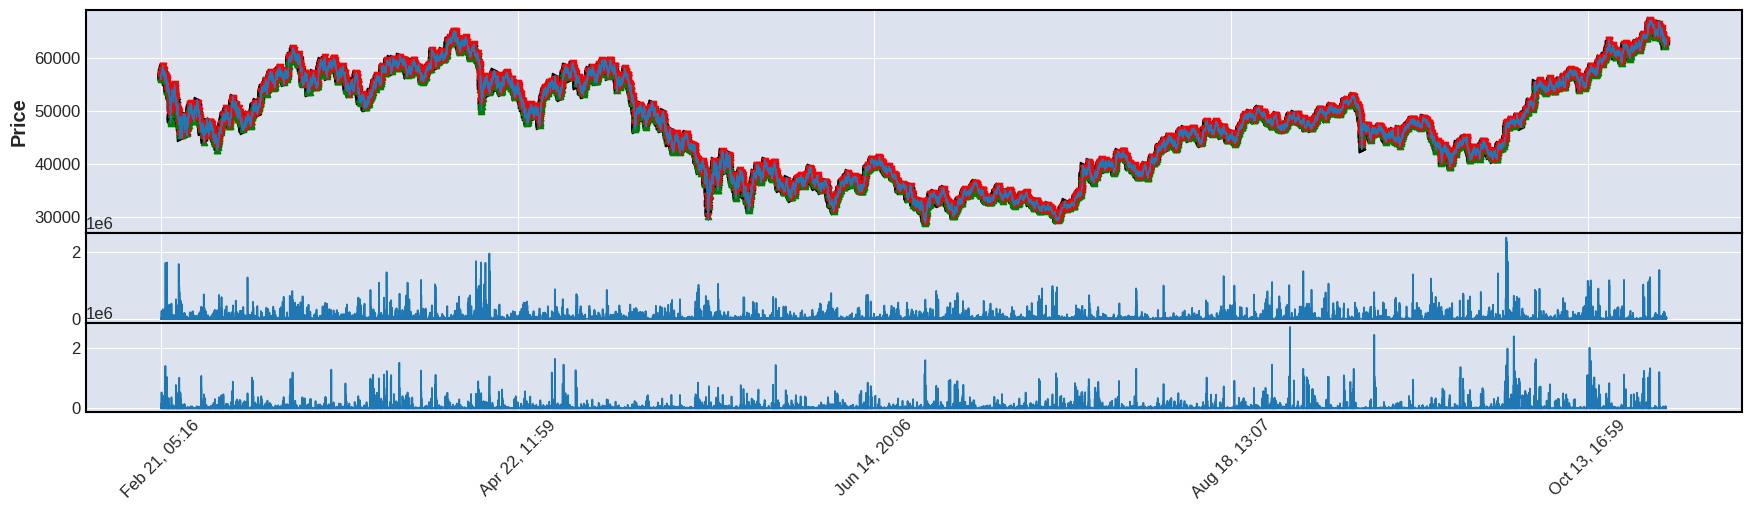

In [8]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin.pkl')

bin_0_index = meta_labels[meta_labels['bin'] == 0].index
df_dollar.loc[:,'bin_0_marker'] = np.nan
df_dollar.loc[bin_0_index, 'bin_0_marker'] = df_dollar.loc[bin_0_index, 'close']

bin_1_index = meta_labels[meta_labels['bin'] == 1].index
df_dollar.loc[:,'bin_1_marker'] = np.nan
df_dollar.loc[bin_1_index, 'bin_1_marker'] = df_dollar.loc[bin_1_index, 'close']

bin_m1_index = meta_labels[meta_labels['bin'] == -1].index
df_dollar.loc[:,'bin_m1_marker'] = np.nan
df_dollar.loc[bin_m1_index, 'bin_m1_marker'] = df_dollar.loc[bin_m1_index, 'close']

df_dollar.to_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin_binmarker.pkl')

df_dollar = df_dollar.set_index('time_from', drop = False)
apd = [mpf.make_addplot(df_dollar['liquidation_sell_volume'], panel = 1),
       mpf.make_addplot(df_dollar['liquidation_buy_volume'], panel = 2),
       mpf.make_addplot(df_dollar['bin_0_marker'], type='scatter', marker='>', color='black', markersize = 20, panel = 0),
       mpf.make_addplot(df_dollar['bin_1_marker'], type='scatter', marker='^', color='green', markersize = 20, panel = 0),
       mpf.make_addplot(df_dollar['bin_m1_marker'], type='scatter', marker='v', color='red', markersize = 20, panel = 0)]
mpf.plot(df_dollar, type='line', volume=False, addplot=apd, figratio=(24,6))

In [9]:
import talib
import copy

def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']
    
    orig_columns = df.columns
    
    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
    'liquidation_buy_volume',
    'liquidation_sell_volume'
])

In [10]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin_binmarker.pkl')
df_dollar = calc_features(df_dollar)
df_dollar.to_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin_binmarker_features.pkl')

In [11]:
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

def fit_and_predict(df, features = []):
    # モデル (コメントアウトで他モデルも試してみてください)
    # model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
    model = lgb.LGBMClassifier(objective='multiclass')
    
    # アンサンブル (コメントアウトを外して性能を比較してみてください)
    # model = BaggingRegressor(model, random_state=1, n_jobs=1)

    # 本番用モデルの学習 (このチュートリアルでは使わない)
    # 実稼働する用のモデルはデータ全体で学習させると良い
    features_fit_target = copy.deepcopy(features)
    features_fit_target.append('bin')
    
    df_fit_target = df[features_fit_target]
    df_fit_target.where(df_fit_target < sys.float_info.max, np.inf, inplace = True)
    df_fit_target.where(df_fit_target > -sys.float_info.max, -np.inf, inplace = True)
    df_fit_target.replace([np.inf, -np.inf], np.nan, inplace =  True)
    df_fit_target.dropna(inplace = True)
    #df_fit_target.reset_index(drop = True, inplace = True)
    
    model.fit(df_fit_target[features], df_fit_target['bin'])
    #joblib.dump(model, 'model_y_buy.xz', compress=True) 

    # 通常のCV
    cv_indicies = list(KFold().split(df_fit_target))
    # ウォークフォワード法
    # cv_indicies = list(TimeSeriesSplit().split(df))
    
    df_fit_target['bin_pred'] = my_cross_val_predict(model, df_fit_target[features].values, df_fit_target['bin'].values, cv=cv_indicies)
    
    fit_target_index = df_fit_target.index
    df.loc[fit_target_index, 'bin_pred'] = df_fit_target.loc[fit_target_index, 'bin_pred']

    return (df, model)

In [12]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin_binmarker_features.pkl')
pd.set_option('display.max_rows', 10)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 100)
(df_dollar, model) = fit_and_predict(df_dollar, features)
df_dollar.to_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin_binmarker_features_predict.pkl')

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:9032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(cond, other, inplace, axis, level, errors=errors)
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret

<AxesSubplot:>

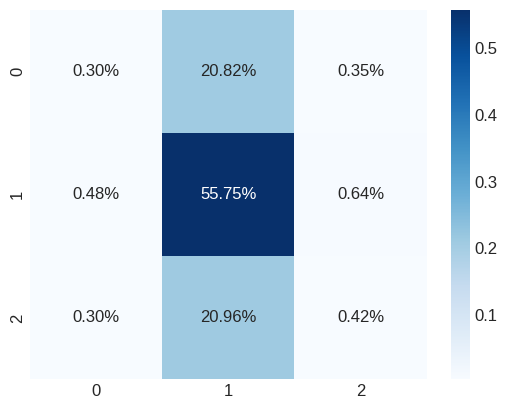

In [13]:
df_dollar = pd.read_pickle('df_dollar_1m_ohlcvl_16Mvolatility_cusummarker_bin_binmarker_features_predict.pkl')
df_dollar_confusion = df_dollar[['bin', 'bin_pred']].dropna(how = 'any')
cf_matrix = confusion_matrix(df_dollar_confusion['bin'], df_dollar_confusion['bin_pred'])
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

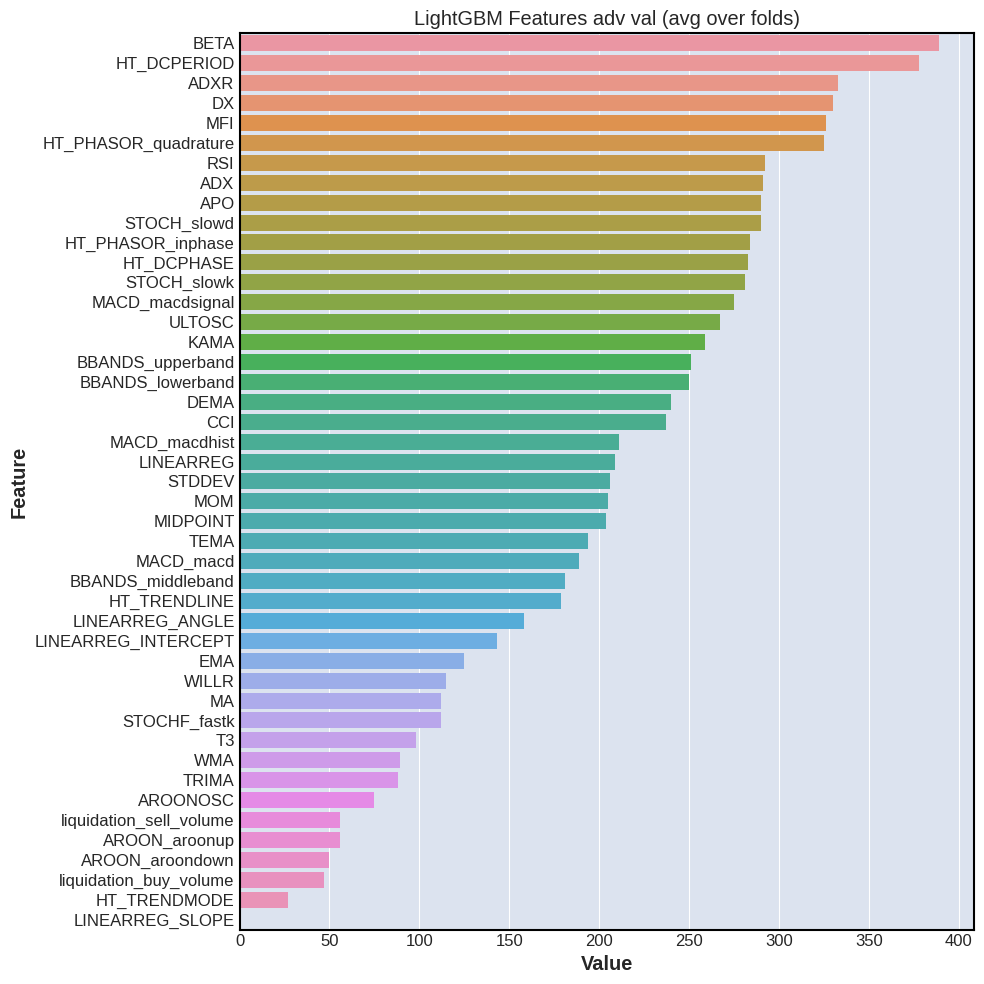

In [14]:
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()